# Практика

In [3]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


# Работа с MNIST

Воспользуемся написанной нейронной сетью для решения задачи распознавания рукописных цифр. Также мы исследуем, как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 51.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [5]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

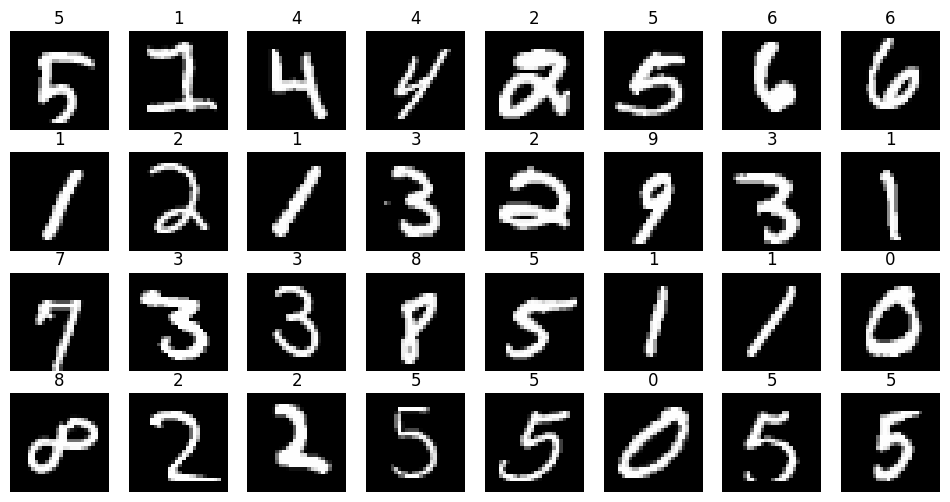

In [6]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

## Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [7]:
X[0].shape

(1, 28, 28)

In [8]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [12]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.309/0.305	Accuracy: 0.919/0.919

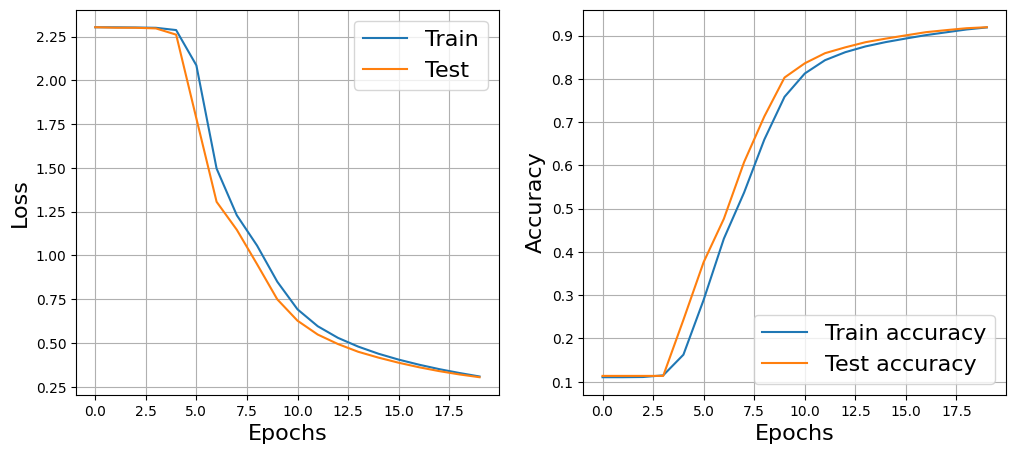

In [ ]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности
Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [11]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.082	Accuracy: 0.986/0.976

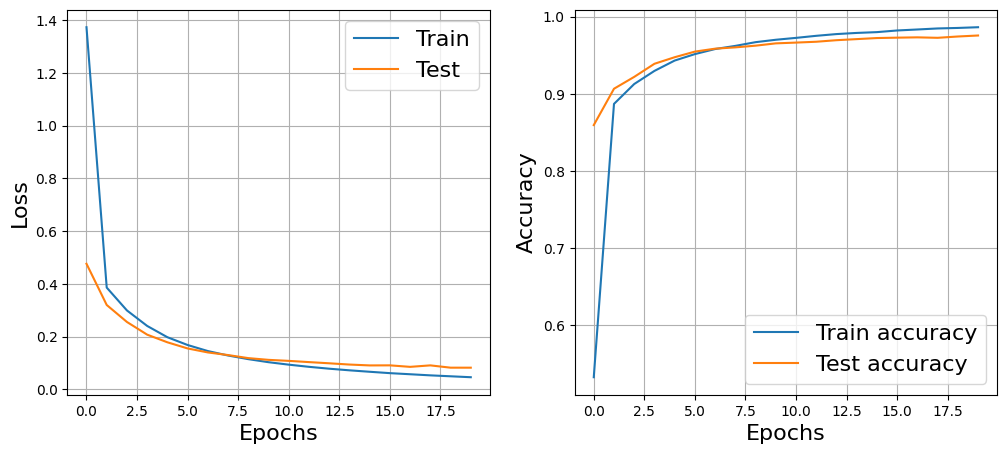

In [ ]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Сравнение результатов

NameError: name 'ts_s' is not defined

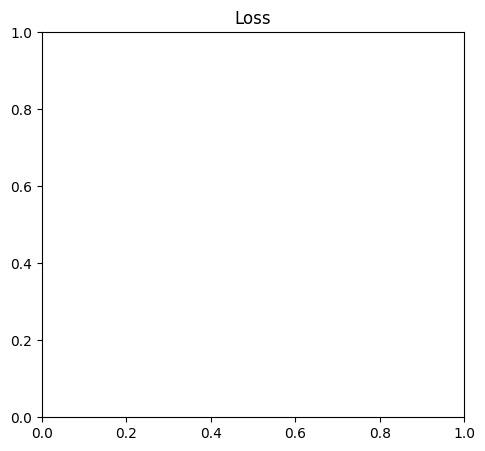

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

# Анализ ошибок

In [ ]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

KeyboardInterrupt: 

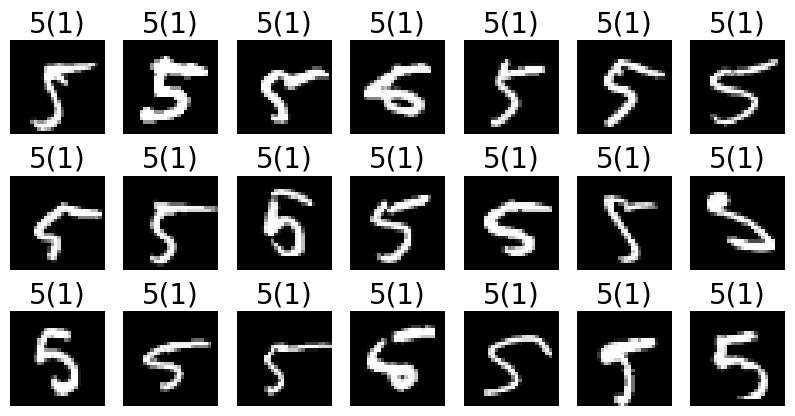

In [ ]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [13]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(self.X)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dLdx = 1 - np.tanh(self.X)**2
        return dLdy*dLdx

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.079	Accuracy: 0.994/0.976

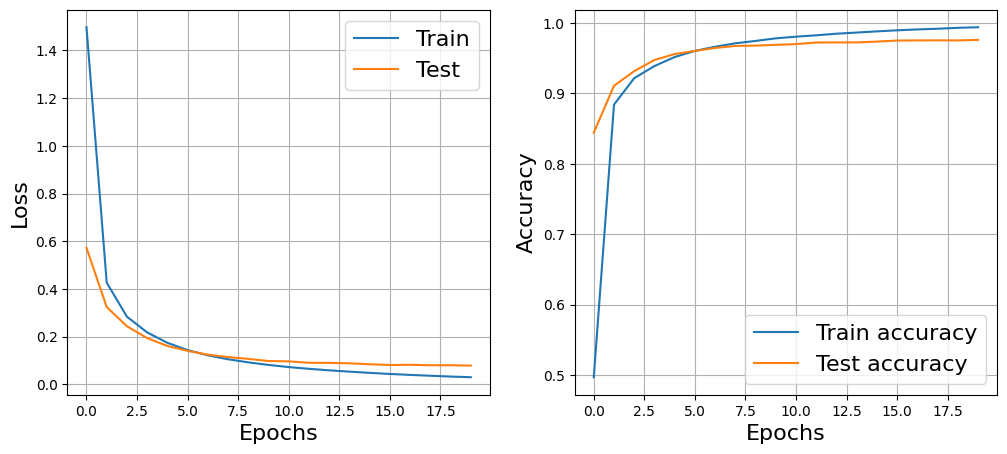

In [ ]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

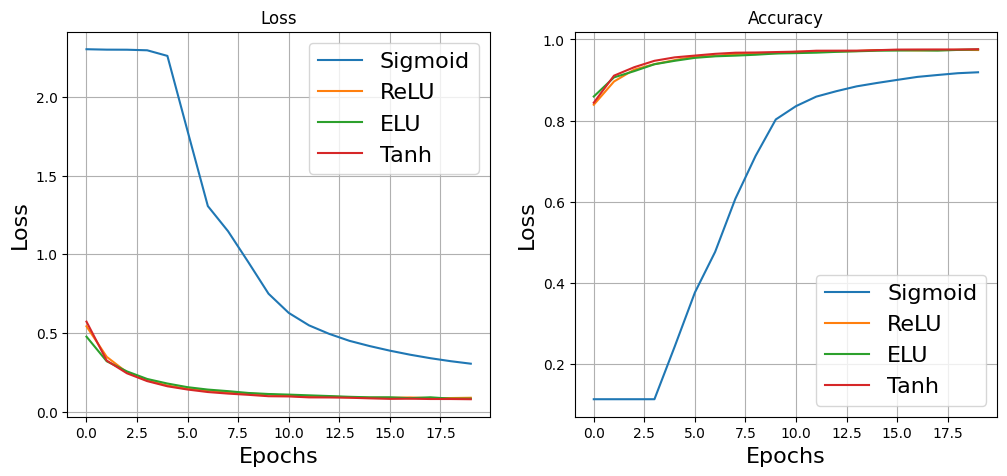

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

## Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

In [14]:
from skimage import transform
from skimage.transform import rotate, AffineTransform,warp
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
import random
from skimage import img_as_ubyte
import os

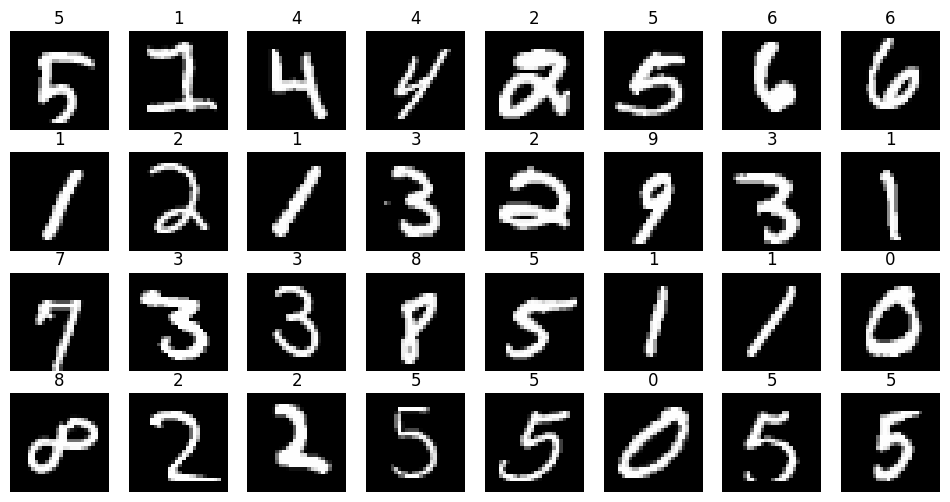

In [15]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Повороты

In [16]:
plt.figure(figsize=(12, 6))
X_rotate_aug = []
y_rotate_aug = []
for i in range(len(X)):
    X_rotate_aug.append(X[i].reshape(28, 28))
    y_rotate_aug.append(y[i])
    angle = random.randint(-15, 15)
    X_rotate_aug.append(rotate(X[i].reshape(28, 28), angle=angle+(angle==0)*5))
    y_rotate_aug.append(y[i])

<Figure size 1200x600 with 0 Axes>

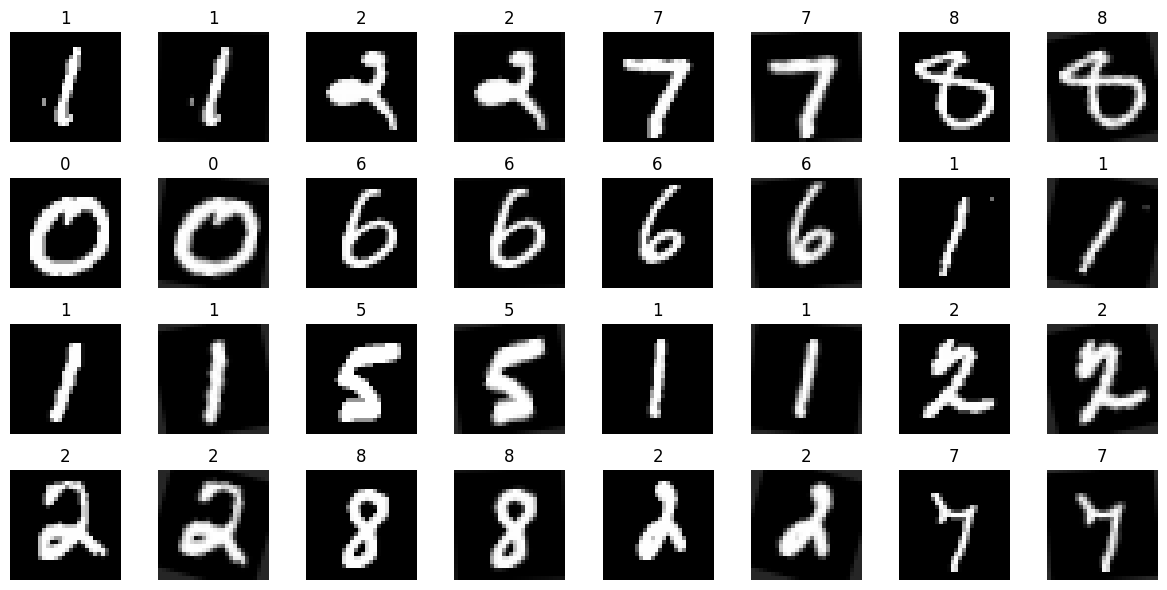

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(min(32, len(X_rotate_aug))):
    plt.subplot(4, 8, i+1)
    plt.imshow(X_rotate_aug[i], cmap=plt.cm.Greys_r)
    plt.title(y_rotate_aug[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# Сдвиги

In [17]:
def shift(image, vector):
    transform = AffineTransform(translation=vector)
    shifted = warp(image, transform, mode='wrap', preserve_range=True)
    shifted = shifted.astype(image.dtype)
    return shifted

plt.figure(figsize=(12, 6))
X_shift_aug = []
y_shift_aug = []

for i in range(len(X)):
    X_shift_aug.append(X[i].reshape(28, 28))
    y_shift_aug.append(y[i])

    vector = (random.randint(-5, 5), random.randint(-5, 5))
    shifted_image = shift(X[i].reshape(28, 28), vector)
    X_shift_aug.append(shifted_image)
    y_shift_aug.append(y[i])

<Figure size 1200x600 with 0 Axes>

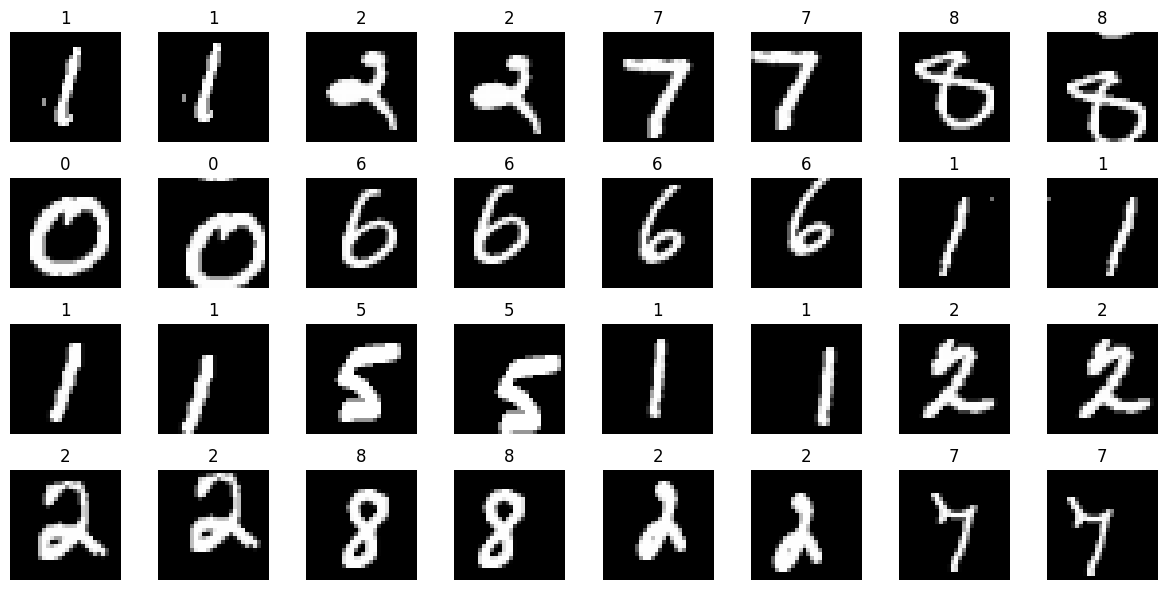

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(min(32, len(X_shift_aug))):
    plt.subplot(4, 8, i+1)
    plt.imshow(X_shift_aug[i], cmap=plt.cm.Greys_r)
    plt.title(y_shift_aug[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# Шум

In [18]:

plt.figure(figsize=(12, 6))
X_noise_aug = []
y_noise_aug = []
for i in range(len(X)):
    X_noise_aug.append(X[i].reshape(28, 28))
    y_noise_aug.append(y[i])
    X_noise_aug.append(random_noise(X[i].reshape(28, 28), mode='s&p',amount=0.3))
    y_noise_aug.append(y[i])

<Figure size 1200x600 with 0 Axes>

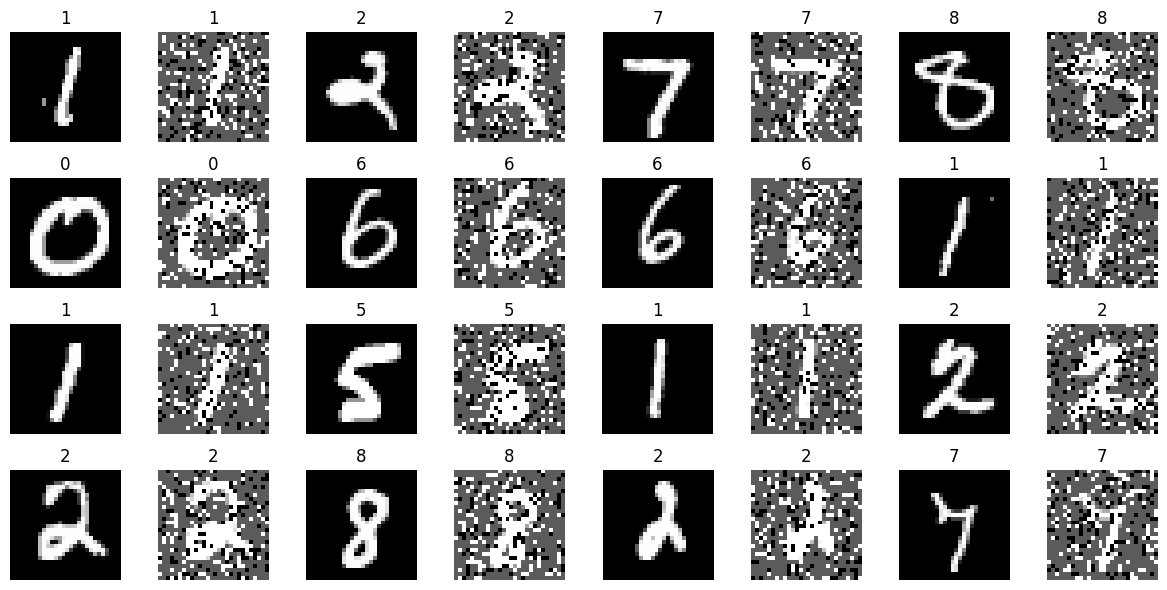

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(min(32, len(X_noise_aug))):
    plt.subplot(4, 8, i+1)
    plt.imshow(X_noise_aug[i], cmap=plt.cm.Greys_r)
    plt.title(y_noise_aug[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# Проверка

Epoch 9... (Train/Test) NLL: 0.742/0.670	Accuracy: 0.792/0.819

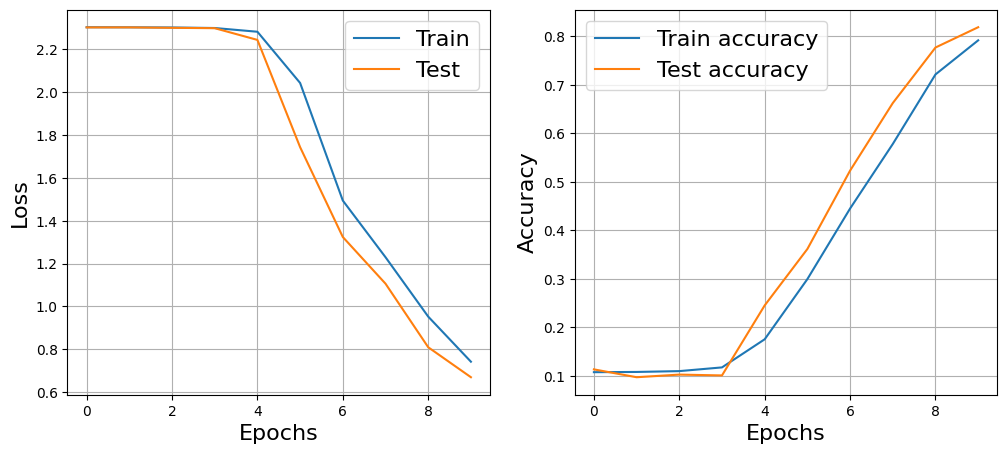

In [ ]:
train_loss_0, test_loss_0, train_acc_0, test_acc_0 = train(network, 10, 0.01, plot=True, verbose=True)

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 9... (Train/Test) NLL: 0.738/0.670	Accuracy: 0.782/0.815

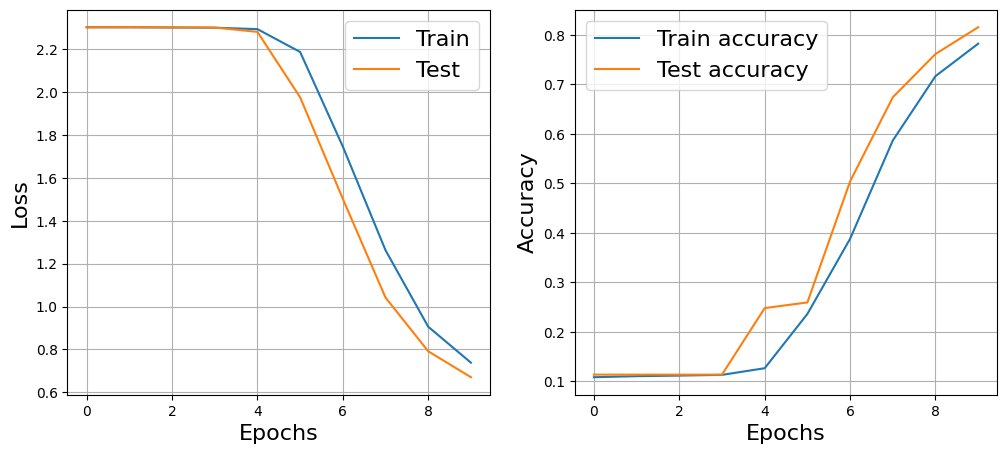

In [ ]:
X_aug, y_aug = np.array(X_rotate_aug), np.array(y_rotate_aug)
train_loss_rot, test_loss_rot, train_acc_rot, test_acc_rot = train(network, 10, 0.01, plot=True, verbose=True)

In [1]:
X_aug, y_aug = np.array(X_shift_aug), np.array(y_shift_aug)
train_loss_shift, test_loss_shift, train_acc_shift, test_acc_shift = train(network, 10, 0.01, plot=True, verbose=True)

NameError: name 'np' is not defined

In [ ]:
X_aug, y_aug = np.array(X_noise_aug), np.array(y_noise_aug)
train_loss_noise, test_loss_noise, train_acc_noise, test_acc_noise = train(network, 10, 0.01, plot=True, verbose=True)

In [ ]:
X_aug = np.concatenate([X_rotate_aug, X_shift_aug, X_noise_aug])
y_aug = np.concatenate([y_rotate_aug, y_shift_aug, y_noise_aug])
train_loss_all, test_loss_all, train_acc_all, test_acc_all = train(network, 10, 0.01, plot=True, verbose=True)

# через тензорфлоу

In [28]:
import torchvision.transforms as transforms
import torch


base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


rotate_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


shift_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


class AddNoise(object):
    def __init__(self, sigma=0.1):
        self.sigma = sigma
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.sigma
        return torch.clamp(tensor + noise, 0., 1.)

noise_transform = transforms.Compose([
    transforms.ToTensor(),
    AddNoise(0.1),

    transforms.Normalize((0.1307,), (0.3081,))
])


all_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    AddNoise(0.1),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [29]:
def get_dataloaders(transform):
    train_dataset = MNIST('.', train=True, download=True, transform=transform)
    test_dataset = MNIST('.', train=False, transform=base_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return train_loader, test_loader

loaders = {
    "baseline": get_dataloaders(base_transform),
    "rotate": get_dataloaders(rotate_transform),
    "shift": get_dataloaders(shift_transform),
    "noise": get_dataloaders(noise_transform),
    "all": get_dataloaders(all_transform),
}


Epoch 9... (Train/Test) NLL: 0.094/0.110	Accuracy: 0.973/0.966

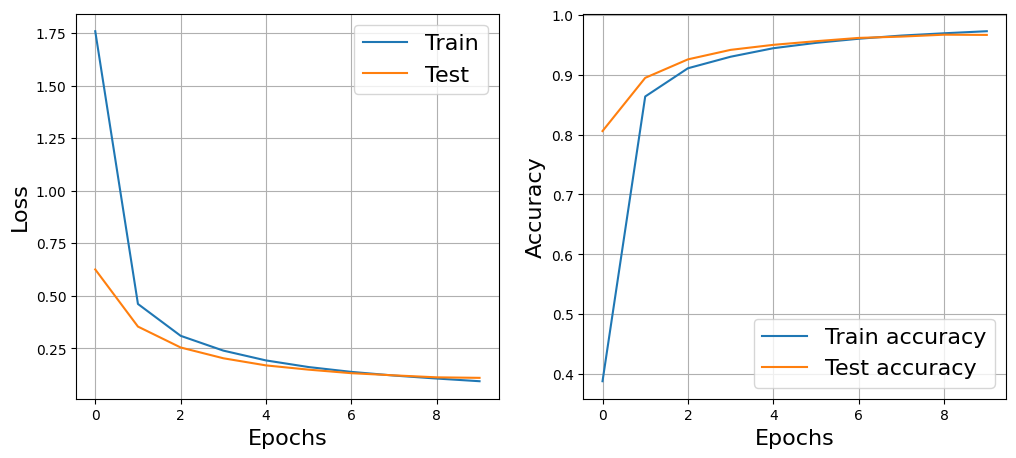

In [32]:
train_loader, test_loader = get_dataloaders(base_transform)

print("=== Baseline (без аугментаций) ===")
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results["baseline"] = train(network, epochs=10, learning_rate=0.01, verbose=True, plot=True)


Epoch 9... (Train/Test) NLL: 0.124/0.104	Accuracy: 0.963/0.968

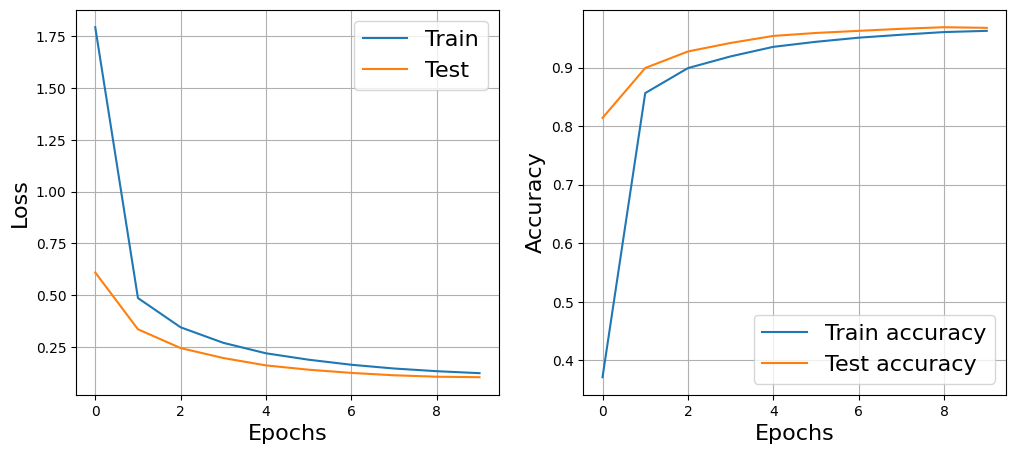

In [34]:
train_loader, test_loader = get_dataloaders(rotate_transform)

print("=== Rotate (вращения) ===")
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results["rotate"] = train(network, epochs=10, learning_rate=0.01, verbose=True, plot=True)


Epoch 9... (Train/Test) NLL: 0.177/0.109	Accuracy: 0.947/0.967

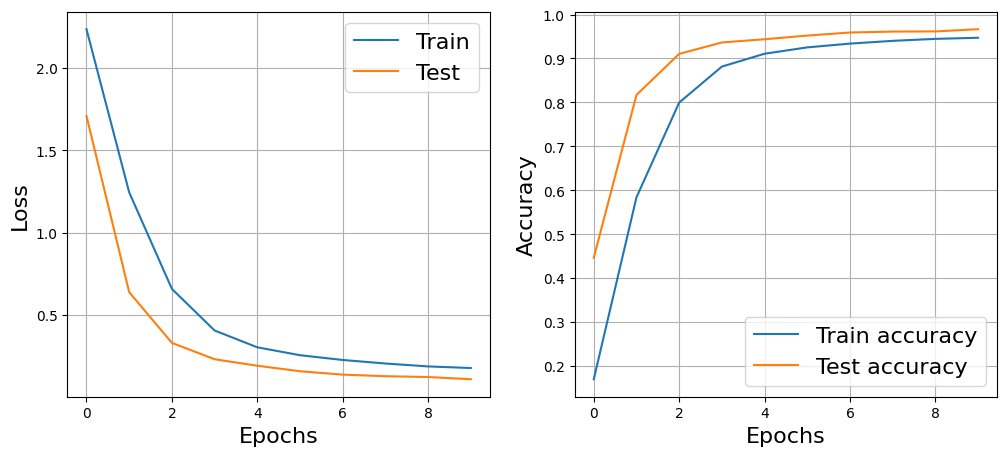

In [35]:
train_loader, test_loader = get_dataloaders(shift_transform)

print("=== Shift (вращения) ===")
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results["shift"] = train(network, epochs=10, learning_rate=0.01, verbose=True, plot=True)


Epoch 9... (Train/Test) NLL: 0.096/0.109	Accuracy: 0.972/0.969

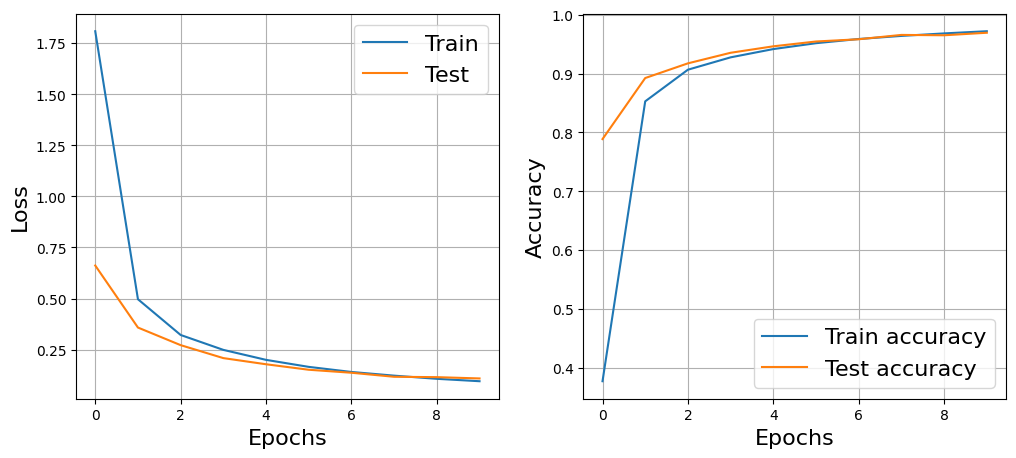

In [36]:
train_loader, test_loader = get_dataloaders(noise_transform)

print("=== Noise (вращения) ===")
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results["noise"] = train(network, epochs=10, learning_rate=0.01, verbose=True, plot=True)


Epoch 9... (Train/Test) NLL: 0.232/0.116	Accuracy: 0.931/0.963

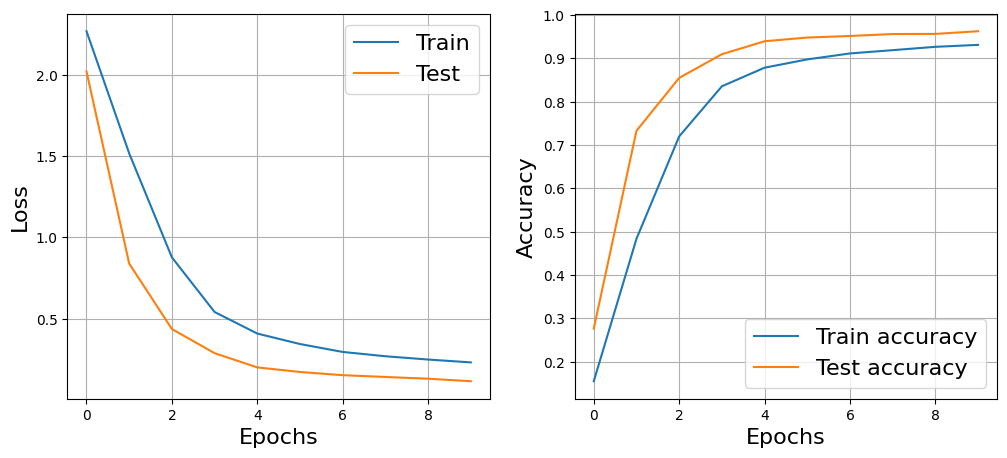

In [37]:
train_loader, test_loader = get_dataloaders(all_transform)

print("=== All (вращения) ===")
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results["all"] = train(network, epochs=10, learning_rate=0.01, verbose=True, plot=True)


https://www.codespeedy.com/image-augmentation-using-skimage-in-python/